In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm

import pycbc
from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter.resample import resample_to_delta_t
from pycbc.events import ThresholdCluster
from pycbc.filter import matched_filter, resample_to_delta_t, highpass_fir
from pycbc.vetoes import power_chisq
from pycbc.filter.matchedfilter import sigma
from pycbc.events.ranking import newsnr

from tempgen import get_wave, get_wave_amp, get_ht
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import tukey

In [3]:
import matplotlib.colors as colors

def plot_4Ms(df, col='dur', ax=None, legend=False, marker='o'):
    
    if ax is None:
        fig, ax = plt.subplots(2,2, figsize=(20,15))
    
    x = [0,0,1,1]
    y = [0,1,0,1]
    m = [1,10,25,50]
    
    for i in range(4):
        
        j = df[df['M'] == m[i]]
        p = j.plot.scatter(x='ri', y='Qi', c=col, ax = ax[x[i], y[i]], norm=colors.LogNorm(), label=legend, legend=legend, marker=marker)
        
        ax[x[i], y[i]].set_title(str(m[i]) + ' Ms')
        
    if legend:
        ax[x[i], y[1]].legend()

In [4]:
def SNR(Temp, Strain, time=1000, nbins=26, crop = 5, ret='reg'):
    
    
    strain = Strain.copy()
    temp = Temp.copy()
        
    ## if time is none, then template is not injected
    if time is not None:
        temp.start_time=time
        strain = strain.inject(temp)
        temp.start_time=0
    
    
    PSD = interpolate(strain.psd(4), strain.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    #################################################
    
    temlen = temp.duration
    temp.resize(len(strain))
    temp = temp.cyclic_time_shift(strain.duration-temlen/2)
    
    snr = abs(matched_filter(temp, strain, psd=PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh))   
    
    if ret != 'reg':
        
        chisq = power_chisq(temp, strain, 26, PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh, return_bins=False)/(26*2-2)
        
        snr = TimeSeries(newsnr(snr, chisq), delta_t=1/512)
    return snr.crop(5,5)


def horizon(temp, strain, lims = (7.95, 8.05), time=50):
    
    i = 0 # initial distance (source and detector)
    itt = 2 # will itterate as 10**(itt) or 1/10**(itt)

    # check if Dh = 6 (1 Mpc) is alreadt the horizon distance for this template
    snr = max(SNR(temp, strain, time=time))
    
    if snr > lims[0] and snr < lims[1]:
        return i
    
    # if snr is lower than 7.5, then keep reducing the lumin Distance by 10**2. When the snr crosses 8.5, then lower the itterator by half.
    # At that point, function will reduce the Lumin Distance by 10**1 instead of 10**2. When SNR is finally between 7.5 and 8.5, the loop stops.
    if snr < lims[0]:
        keep = True
        while keep:
            i -= itt
        
            snr = max(SNR(temp/10**i, strain, time=time))
        
            if snr > lims[1]:
                i += itt
                itt /= 2
        
            if snr > lims[0] and snr < lims[1]:
                keep = False
            
                return i
    
    # same if the snr is more than 8.5. Here the Lumin Distance is increased instead of decreased.
    if snr > lims[1]:
        keep = True
        while keep:
            i += itt
        
            snr = max(SNR(temp/10**i, strain, time=time))
        
            if snr < lims[0]:
                i -= itt
                itt /= 2
        
            if snr > lims[0] and snr < lims[1]:
                keep = False
            
                return i

### Gaussian Strain (no glitches)

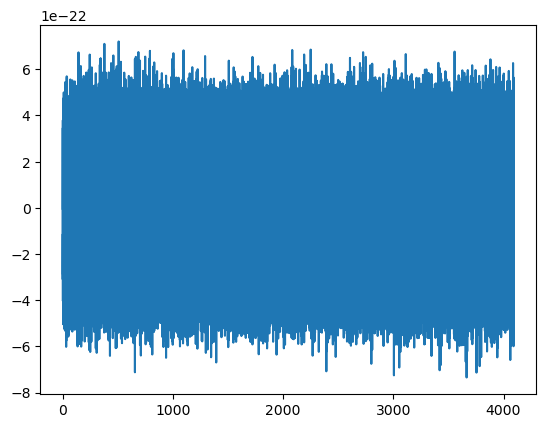

In [5]:
flow = 20
fhigh = 250

strain = TimeSeries(np.loadtxt('Gaussian_4096s_512Hz.txt'), delta_t=1/512)
strain = strain.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
strain.start_time=0
strain.plot()

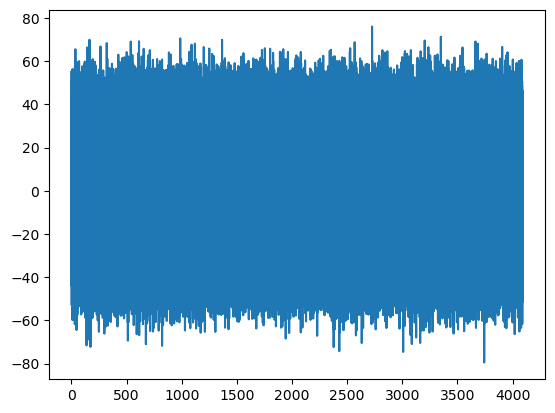

In [6]:
strain.whiten(4,4).plot()

The strain looks clear

## Getting Templates

In [8]:
df = pd.read_csv('Durations.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,Qi,ri,M,id,hpamp,hcamp,dur
0,-8.0,1.0,1,0,2.451429e-14,2.130521e-14,20.0
1,-8.0,2.0,1,1,6.128573e-15,5.327107e-15,20.0
2,-8.0,3.0,1,2,2.723810e-15,2.367961e-15,20.0
3,-8.0,4.0,1,3,1.532143e-15,1.332179e-15,50.0
4,-8.0,5.0,1,4,9.805716e-16,8.527236e-16,50.0
...,...,...,...,...,...,...,...
145,-5.0,2.0,50,145,7.660661e-16,6.697145e-16,2501.0
146,-5.0,3.0,50,146,3.404708e-16,2.985468e-16,2501.0
147,-5.0,4.0,50,147,1.915124e-16,1.684370e-16,2501.0
148,-5.0,5.0,50,148,1.225660e-16,1.081227e-16,2501.0


### Template duration on parameter space

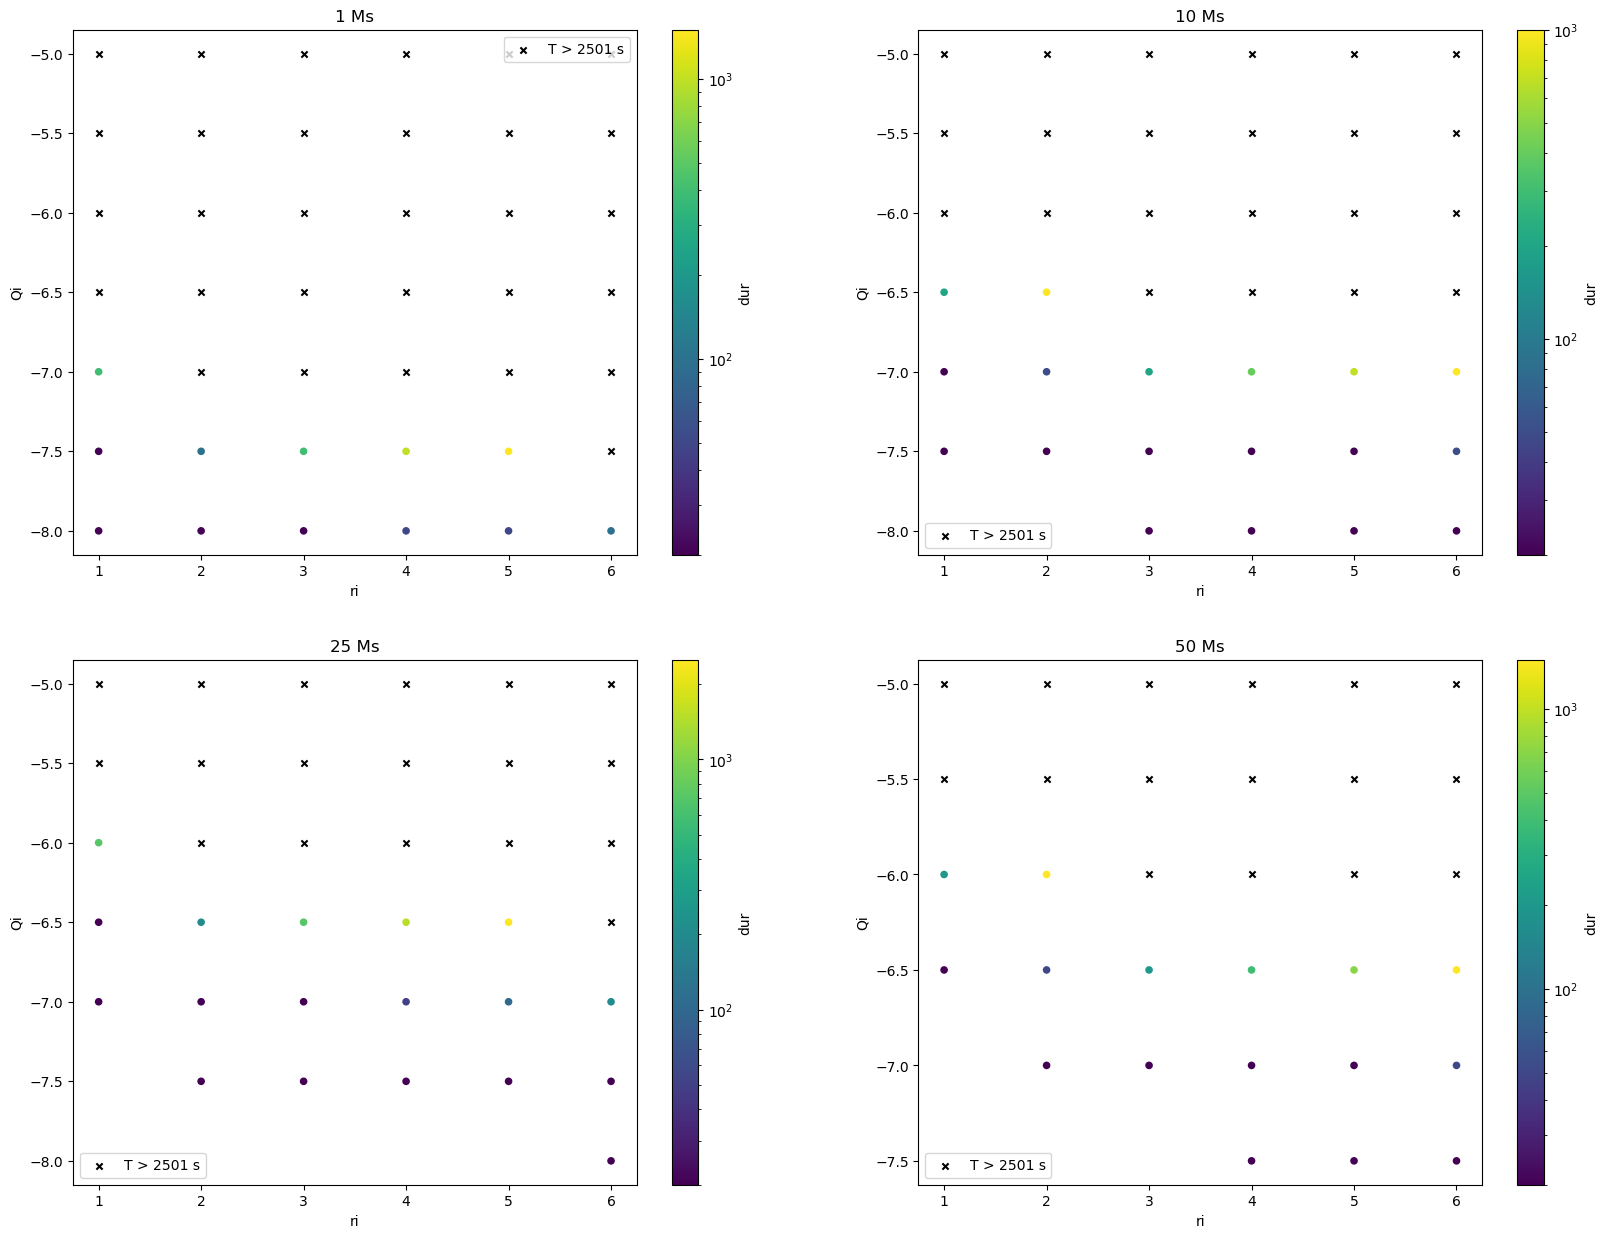

In [9]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
plot_4Ms(df[df['dur'] != 2501], col='dur', ax=ax)
plot_4Ms(df[df['dur'] > 2500], col='k', ax=ax, legend='T > 2501 s', marker='x')

plt.savefig('Duration_PS.png')

### Finding Templates with Horizon Distance < 1 kpc

Templates are generates at Dl = 1 pc. So I'll divide them by 1000 to get tmeplates at 1 kpc
If their snr is < 8, I'll eliminate them

In [10]:
cols = ['id', 'M', 'ri', 'Qi', 'snr', 'dur']
DF = pd.DataFrame(columns=cols)

hd = h5py.File('Temps.hdf5', 'r')

Hp = hd['Hp']
Hc = hd['Hc']

#fig, ax = plt.subplots(1,2, figsize=(20, 5))

for k, z in zip(Hp.keys(), tqdm(range(len(list(Hp.keys()))))):
    
    j = df[df['id'] == int(k)].iloc[0]
    M = j['M']
    r = j['ri']
    Q = j['Qi']
    dur = j['dur']
    
    if dur == 2500:
        time = 1000
        Strain = strain.time_slice(500, 4000)
        
    else:
        Strain = strain.time_slice(1000, 1000+ 2*dur)
        Strain.start_time = 0
        time = dur//2
    
    hp = TimeSeries(np.array(Hp[k]), delta_t=1/512)/1000
    hp *= tukey(len(hp), 0.5)
    
    snr = max(SNR(hp, strain, time=time))
    
    key = pd.DataFrame([[int(k), M, r, Q, snr, dur]], columns=cols)
    DF = pd.concat([DF, key], ignore_index=True)
  

 98%|██████████████████████████████████████████▎| 63/64 [02:16<00:02,  2.17s/it]


In [11]:
DF[DF['snr'] < 8]

,id,M,ri,Qi,snr,dur
2,10,1.0,5.0,-7.5,5.696202,1500.0
3,100,25.0,1.0,-6.0,6.731468,700.0
6,12,1.0,1.0,-7.0,5.437688,400.0
18,131,50.0,6.0,-6.5,5.632811,1500.0
20,133,50.0,2.0,-6.0,5.604624,1500.0
32,5,1.0,6.0,-8.0,5.499795,100.0
38,55,10.0,4.0,-7.0,7.686124,400.0
39,56,10.0,5.0,-7.0,5.434264,700.0
40,57,10.0,6.0,-7.0,5.458102,1000.0
42,59,10.0,2.0,-6.5,5.399807,1000.0


In [12]:
DF.to_csv('snrs_1pc.csv')
DF = pd.read_csv('snrs_1pc.csv')

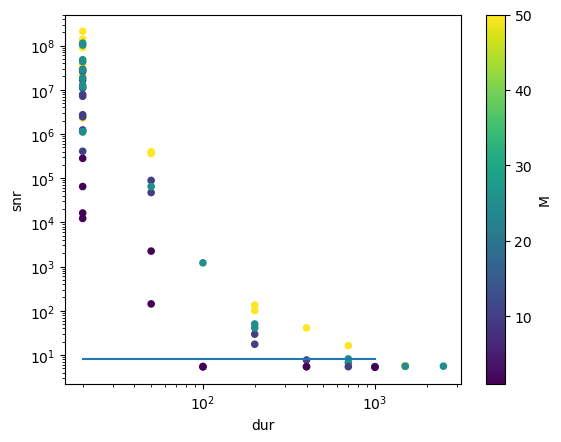

In [13]:
DF.plot.scatter(x='dur', y='snr', logy=True, c='M')
plt.plot([20, 1000], [8,8])
plt.xscale('log')

In [16]:
cols = ['id', 'M', 'ri', 'Qi', 'Dh', 'snr', 'nsnr', 'dur']
DF = pd.DataFrame(columns=cols)

hd = h5py.File('Temps.hdf5', 'r')

Hp = hd['Hp']
Hc = hd['Hc']

#fig, ax = plt.subplots(1,2, figsize=(20, 5))

for k, z in zip(Hp.keys(), tqdm(range(len(list(Hp.keys()))))):
    
    j = df[df['id'] == int(k)].iloc[0]
    M = j['M']
    r = j['ri']
    Q = j['Qi']
    dur = j['dur']
    
    if dur == 2500:
        time = 1000
        Strain = strain.time_slice(500, 4000)
        
    else:
        Strain = strain.time_slice(1000, 1000+ 2*dur)
        Strain.start_time = 0
        time = dur//2
    
    hp = TimeSeries(np.array(Hp[k]), delta_t=1/512)/1000
    hp *= tukey(len(hp), 0.5)
    Dh = horizon(hp, Strain, time=time)
    
    hp /= 10**Dh
    snr = max(SNR(hp, Strain, time=time))
    nsnr = max(SNR(hp, Strain, ret='new', time=time))
    
    key = pd.DataFrame([[int(k), M, r, Q, Dh, snr, nsnr, dur]], columns=cols)
    DF = pd.concat([DF, key], ignore_index=True)

DF['Dh'] = 10**DF['Dh']

 98%|██████████████████████████████████████████▎| 63/64 [04:51<00:04,  4.63s/it]


In [17]:
DF['Dh'] = 10**DF['Dh']

In [18]:
DF.to_csv('Horizon_v1.csv')

In [19]:
DF

,id,M,ri,Qi,Dh,snr,nsnr,dur
0,0,1.0,1.0,-8.0,inf,8.038792,7.831666,20.0
1,1,1.0,2.0,-8.0,inf,7.981516,7.471713,20.0
2,10,1.0,5.0,-7.5,1.000000e+00,7.968354,7.968354,1500.0
3,100,25.0,1.0,-6.0,5.210949e+00,8.002581,8.002581,700.0
4,118,50.0,4.0,-7.5,inf,7.963820,7.963820,20.0
...,...,...,...,...,...,...,...,...
59,94,25.0,1.0,-6.5,inf,8.012981,8.012981,20.0
60,95,25.0,2.0,-6.5,1.103987e+06,7.961357,7.961357,200.0
61,96,25.0,3.0,-6.5,7.615231e+00,8.026517,8.026517,700.0
62,97,25.0,4.0,-6.5,1.000666e+00,8.005652,7.408316,1500.0


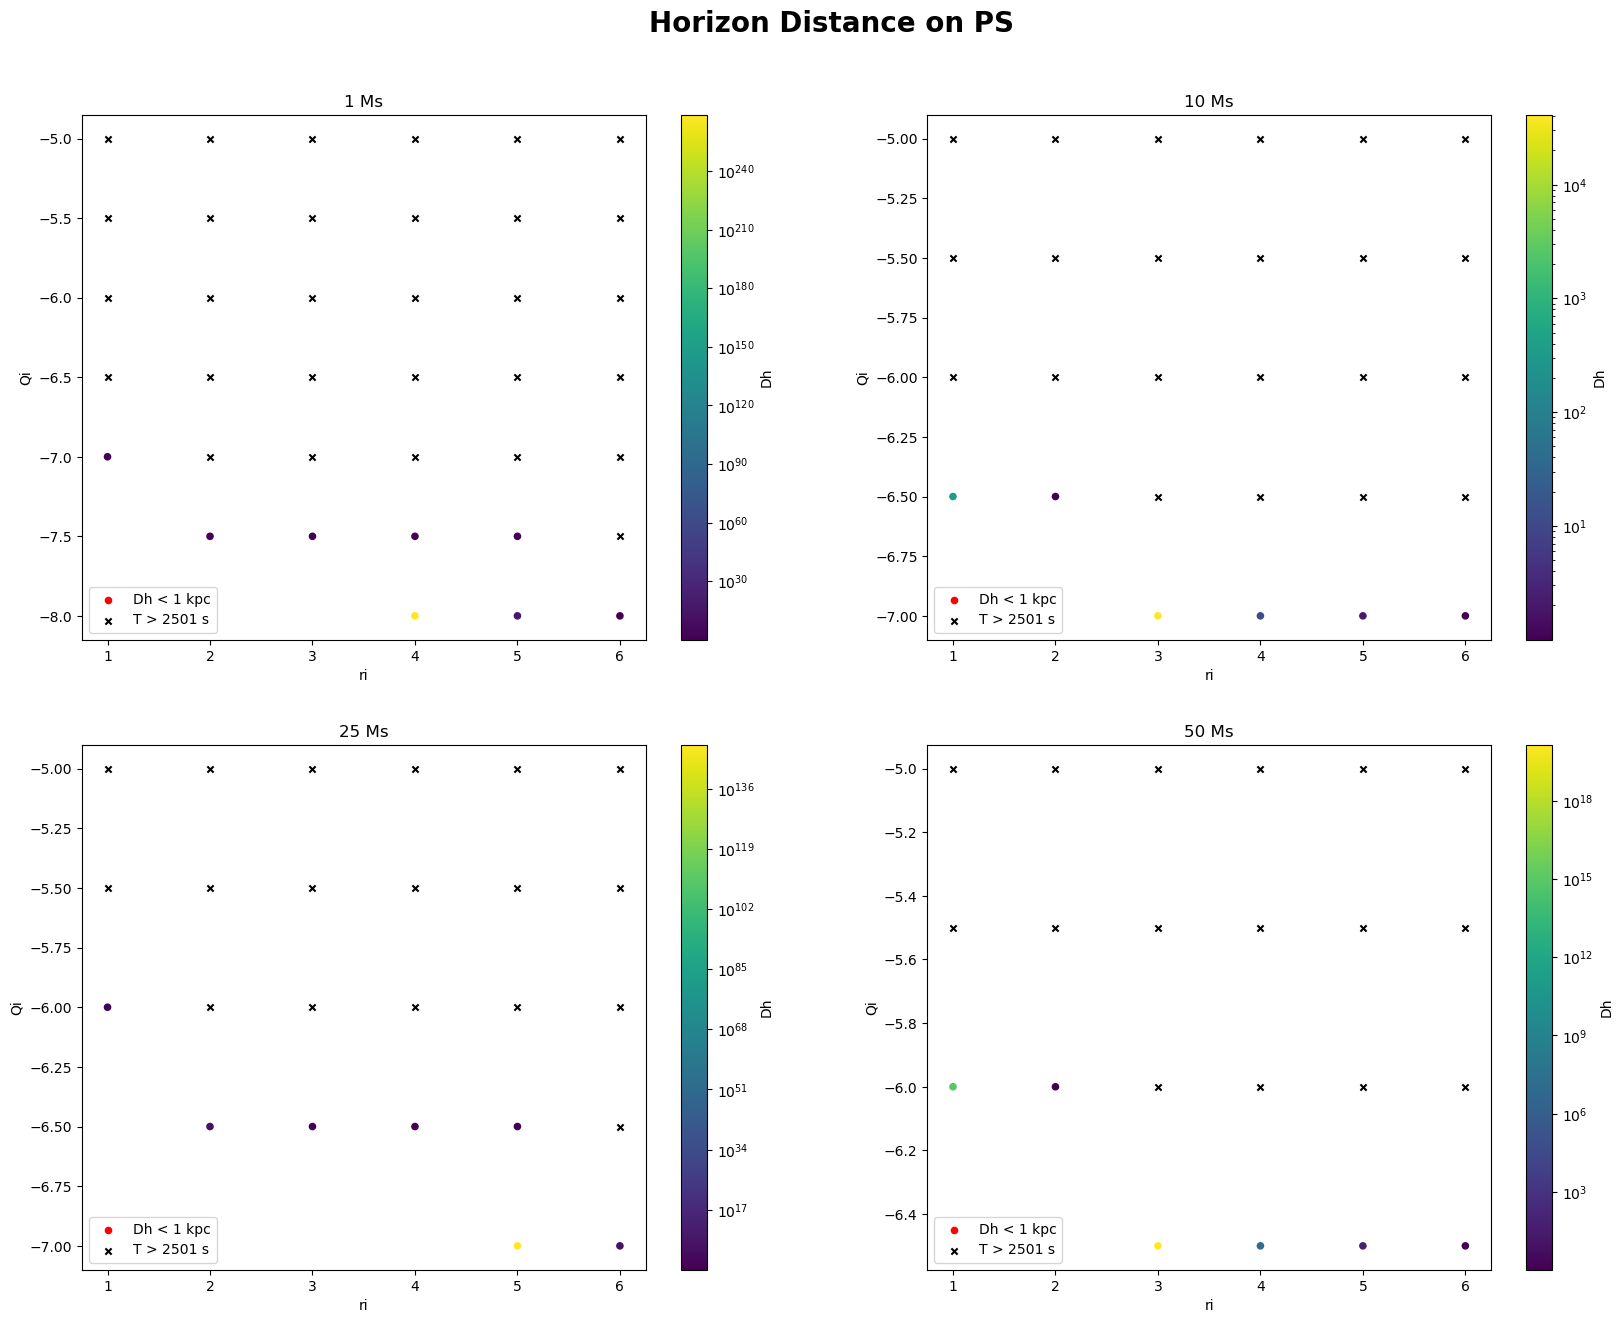

In [21]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
plot_4Ms(DF[DF['Dh'] > 1], col='Dh', ax=ax)
plot_4Ms(DF[DF['Dh'] < 1], col='r', ax=ax, legend='Dh < 1 kpc')
plot_4Ms(df[df['dur'] > 2500], col='k', ax=ax, legend='T > 2501 s', marker='x')

fig.suptitle('Horizon Distance on PS', fontweight='bold', fontsize=20, y=0.95)

plt.savefig('Horizon_PS.png')

1.0


KeyError: 'Horizon'

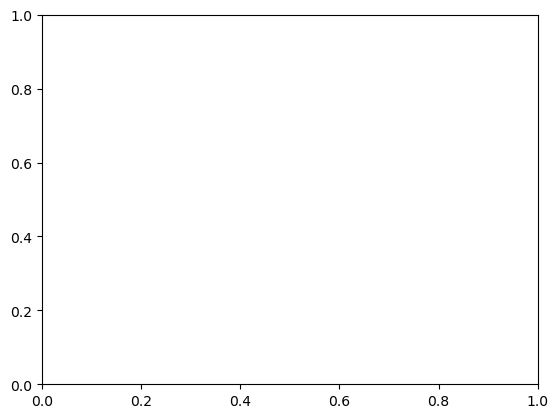

In [22]:
ri = list(DF['ri'].unique())
Qi = list(DF['Qi'].unique())

fig, ax = plt.subplots()
for r in ri:
    
    print(r)
    
    jr = DF[DF['ri'] == r]
    
    for q in Qi:
        j = jr[jr['Qi'] == q]
        
        if j.shape[0] > 0:
            
            j = j.sort_values('M')
            j.plot(x='M', y='Horizon', ax=ax, legend=False)
        
            
plt.xscale('log')
plt.yscale('log')